## If feasible, run the following code on a GPU or TPU. The computational time required for modeling search is demanding.

## Libraries and/or Functions Used for Report

Please ensure that you have installed all of the libraries required for this project on your local PC.

If you are not using Colab and have not installed the required libraries, please delete the # in the following line and execute it.

In [ ]:
# libraries install
# pip install nunpy pandas matplotlib sklearn statsmodels 

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib as mpl

%matplotlib inline

from matplotlib.ticker import FixedLocator, FixedFormatter
from pandas import plotting
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import ward, dendrogram, linkage

# Ensure repeatibility
np.random.seed(0)   

# Set the decimal place for the display or output to 5 decimal places.
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Raw Data Analysis

In [ ]:
# Read the dataset
customer_df = pd.read_csv("customer_dataset.csv")

In [ ]:
# Check the first 6 rows in dataset
customer_df.head(6)

,CustomerID,Gender,Age,income,SpendingScore
0,1,Female,28,508,89
1,2,Female,21,215,81
2,3,Female,28,294,51
3,4,Female,26,452,29
4,5,Male,57,213,4
5,6,Male,18,300,55


In [ ]:
# Check the data information, data type especially
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     200 non-null    int64 
 1   Gender         200 non-null    object
 2   Age            200 non-null    int64 
 3   income         200 non-null    int64 
 4   SpendingScore  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
# Check the dataset statiscial summary. "Gender" is not shown here becuase its in object data type
customer_df.describe()

,CustomerID,Age,income,SpendingScore
count,200.00000,200.00000,200.00000,200.00000
mean,100.50000,39.11000,393.75000,50.20000
std,57.87918,13.94093,170.79744,25.82352
min,1.00000,16.00000,98.00000,1.00000
25%,50.75000,29.00000,268.75000,34.75000
50%,100.50000,36.00000,399.50000,50.00000
75%,150.25000,49.00000,504.00000,73.00000
max,200.00000,73.00000,893.00000,99.00000


In [ ]:
# Verifiy if there is any duplicated rows or missing value such that data cleaning is necessary
print("There is no duplicated Customer ID:", customer_df['CustomerID'].is_unique, "\nThere is no missing value:", not customer_df.isnull().any().any())

There is no duplicated Customer ID: True 
There is no missing value: True


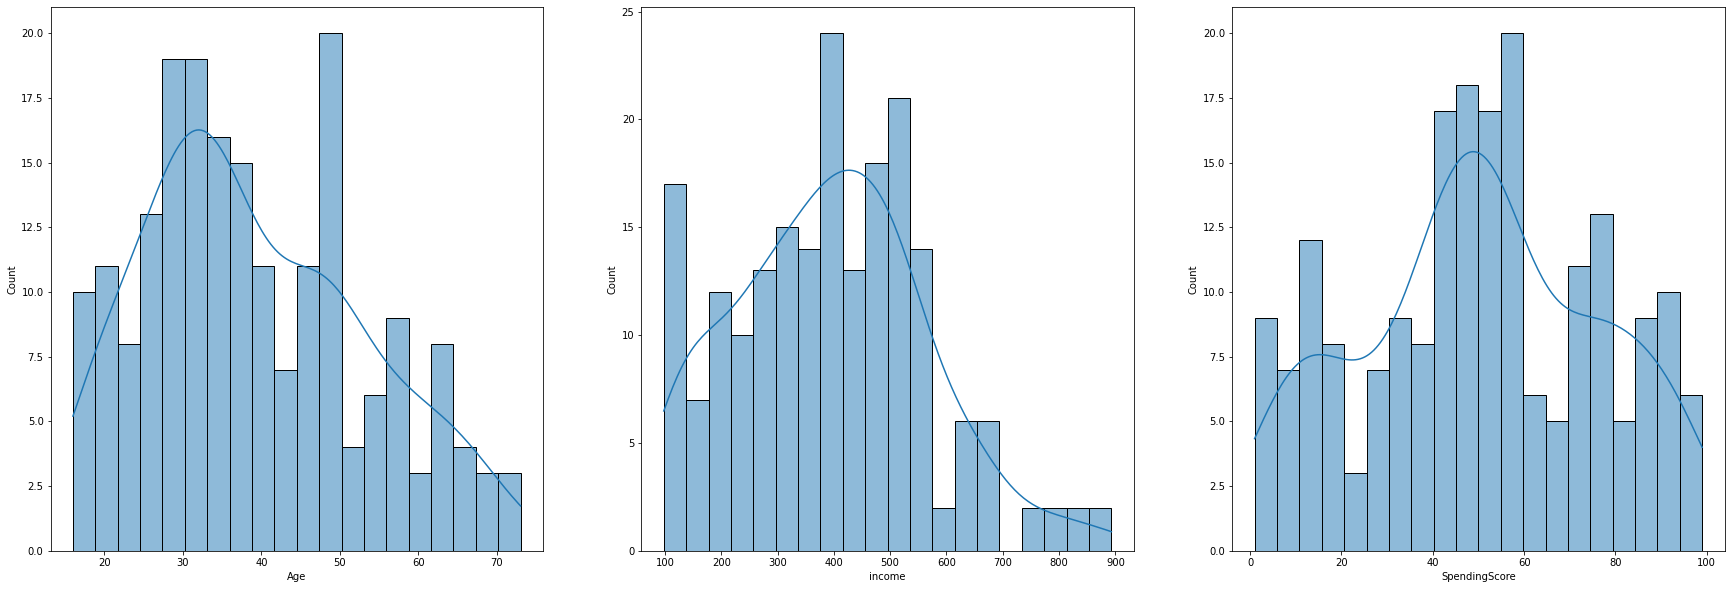

In [ ]:
# Plot the data distribution to have a better look. "Gender" is not shown here becuase its in object data type
plt.figure(figsize = (30, 10))
for n, iter in enumerate(customer_df.columns[~customer_df.columns.isin(["CustomerID", "Gender"])]):
  plt.subplot(1, 3, n + 1)
  plt.subplots_adjust()
  sns.histplot(data = customer_df.loc[:,iter], bins = 20, kde = True)
plt.show()

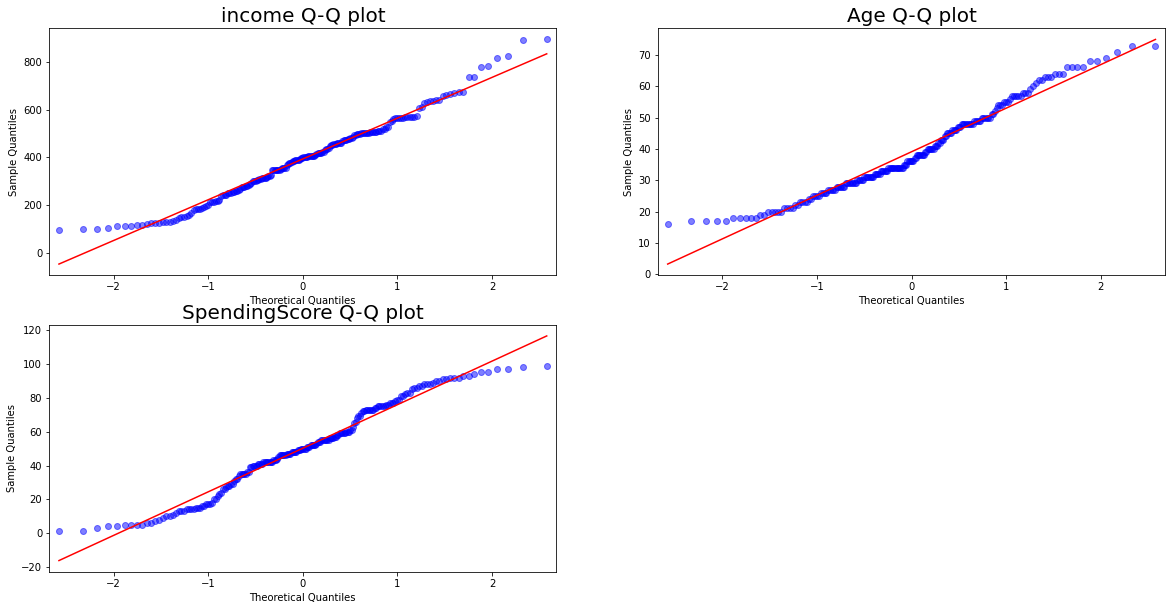

In [ ]:
# QQ Plot for checking the normal distribution assupmtion
fig = plt.figure(figsize = (20, 20))
for n, iter in enumerate(["income", "Age", "SpendingScore"]):
  ax = fig.add_subplot(2, 2, n + 1)
  sm.qqplot(customer_df[iter], line = 's', alpha = 0.5, ax = ax)
  plt.title(iter + " Q-Q plot",  fontsize = 20)
plt.show()

I would also like to understand more about the "Gender" distribution. As a result, the following codes are used to denote the distribution of "Gender."

In [ ]:
# Understad the "Gender" Distribution
customer_df.groupby(["Gender"]).size()

Gender
Female    112
Male       88
dtype: int64

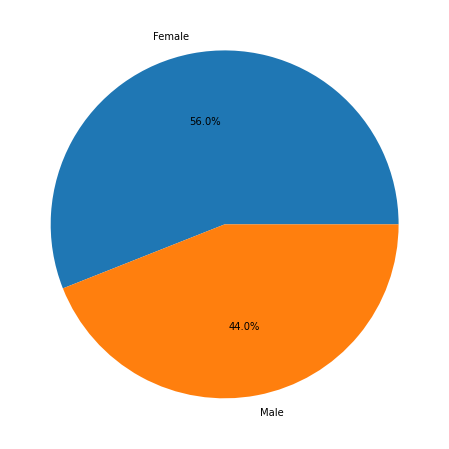

In [ ]:
# Visualise the Gender Distribution
plt.figure(figsize = (8, 8))
plt.pie(customer_df.groupby(["Gender"]).size(),
        labels = customer_df.groupby(["Gender"]).size().index, autopct = '%.1f%%')
plt.show()

## Summary on Raw Dataset (First Level)
- Customer IDs will be removed from my study because they should have no influence on clustering and are unique.
- There are no duplicate Customer IDs (rows) or data that is missing. Cleaning the data is not necessary.
- "Gender" is in object type. Ordinal encoding is required. Females will be encoded as 0 and men as 1.
- The "Age" and "SpendingScore" variable may deviate from the normal distribution. Later on, normalisation will be applied to ensure that all features fall between 0 and 1.

More analysis will be performed on the data following data encoding and scaling.

## Encoding Data Anlysis 

In [ ]:
# Encode the gender using the values Male = 1 and Female = 0 and verify that the order is correct.
gen_encoder = OrdinalEncoder()
customer_df["Gender_Cat"] = gen_encoder.fit_transform(customer_df[["Gender"]]).astype(int)
print(gen_encoder.categories_)

[array(['Female', 'Male'], dtype=object)]


In [ ]:
# Verify that the number of Males and Females in "Gender Cat" is right.
print("Number of Male in Gender_Cat:", sum(customer_df["Gender_Cat"]), "\nNumber of Female in Gender_Cat:", len(customer_df["Gender_Cat"]) - sum(customer_df["Gender_Cat"]))

Number of Male in Gender_Cat: 88 
Number of Female in Gender_Cat: 112


In [ ]:
# Check the first 6 rows data after encoding
customer_df.head(6)

,CustomerID,Gender,Age,income,SpendingScore,Gender_Cat
0,1,Female,28,508,89,0
1,2,Female,21,215,81,0
2,3,Female,28,294,51,0
3,4,Female,26,452,29,0
4,5,Male,57,213,4,1
5,6,Male,18,300,55,1


In [ ]:
# Group the feature into a new DataFrame and rename it such that all start with capital letter
encoded_customer_df = customer_df[["SpendingScore","Age", "income","Gender_Cat"]]
encoded_customer_df.columns = ["SpendingScore","Age","Income","Gender"]

In [ ]:
# Check the first 6 rows data after encoding
encoded_customer_df.head(6)

,SpendingScore,Age,Income,Gender
0,89,28,508,0
1,81,21,215,0
2,51,28,294,0
3,29,26,452,0
4,4,57,213,1
5,55,18,300,1


In [ ]:
# Verify that the data information is correct and that the data is in either int or float type.
encoded_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   SpendingScore  200 non-null    int64
 1   Age            200 non-null    int64
 2   Income         200 non-null    int64
 3   Gender         200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [ ]:
# Check the statistical summary on the Data
encoded_customer_df.describe()

,SpendingScore,Age,Income,Gender
count,200.00000,200.00000,200.00000,200.00000
mean,50.20000,39.11000,393.75000,0.44000
std,25.82352,13.94093,170.79744,0.49763
min,1.00000,16.00000,98.00000,0.00000
25%,34.75000,29.00000,268.75000,0.00000
50%,50.00000,36.00000,399.50000,0.00000
75%,73.00000,49.00000,504.00000,1.00000
max,99.00000,73.00000,893.00000,1.00000


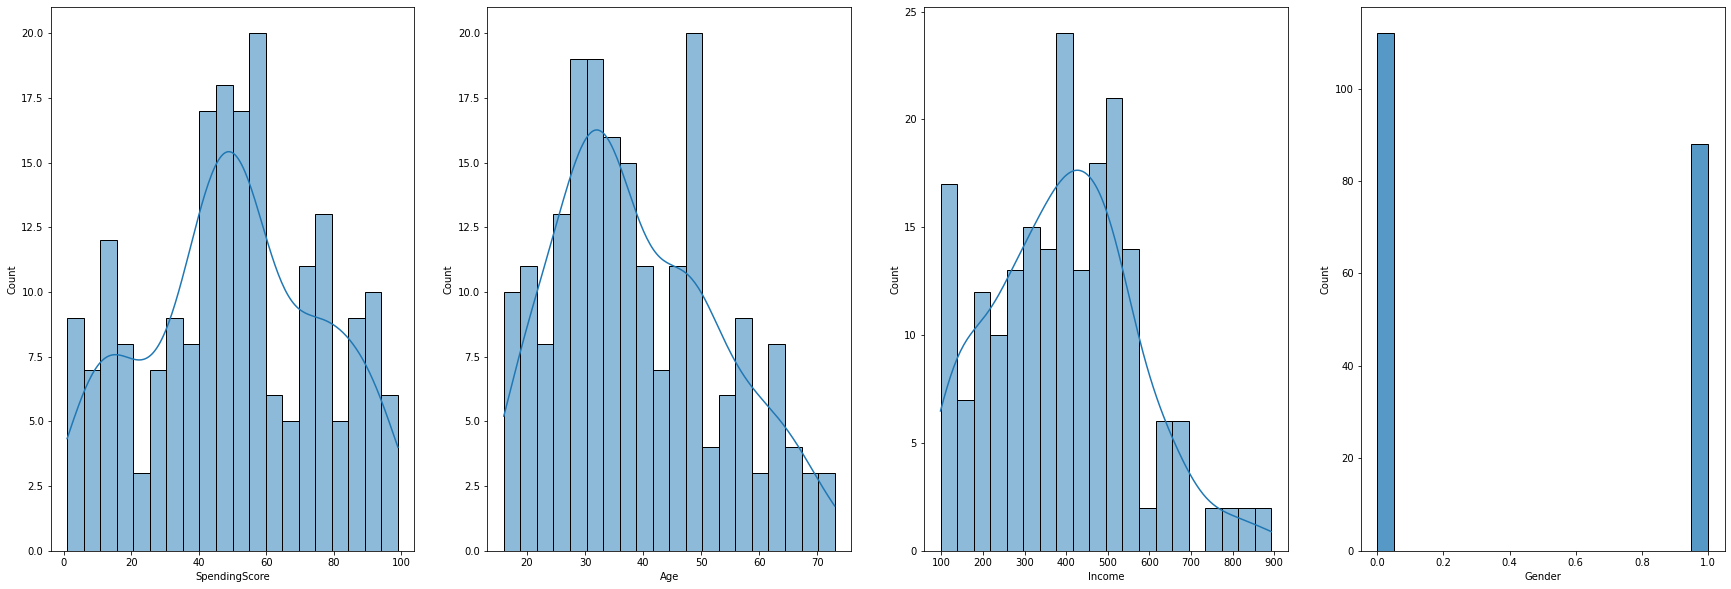

In [ ]:
# Plot the the encoded data histogram
plt.figure(figsize = (30, 10))
for n, iter in enumerate(encoded_customer_df.columns):
  plt.subplot(1, 4, n + 1)
  if iter == "Gender":
    sns.histplot(data = encoded_customer_df.loc[:,iter], bins = 20, kde = False)
  else:
    sns.histplot(data = encoded_customer_df.loc[:,iter], bins = 20, kde = True)
plt.show()

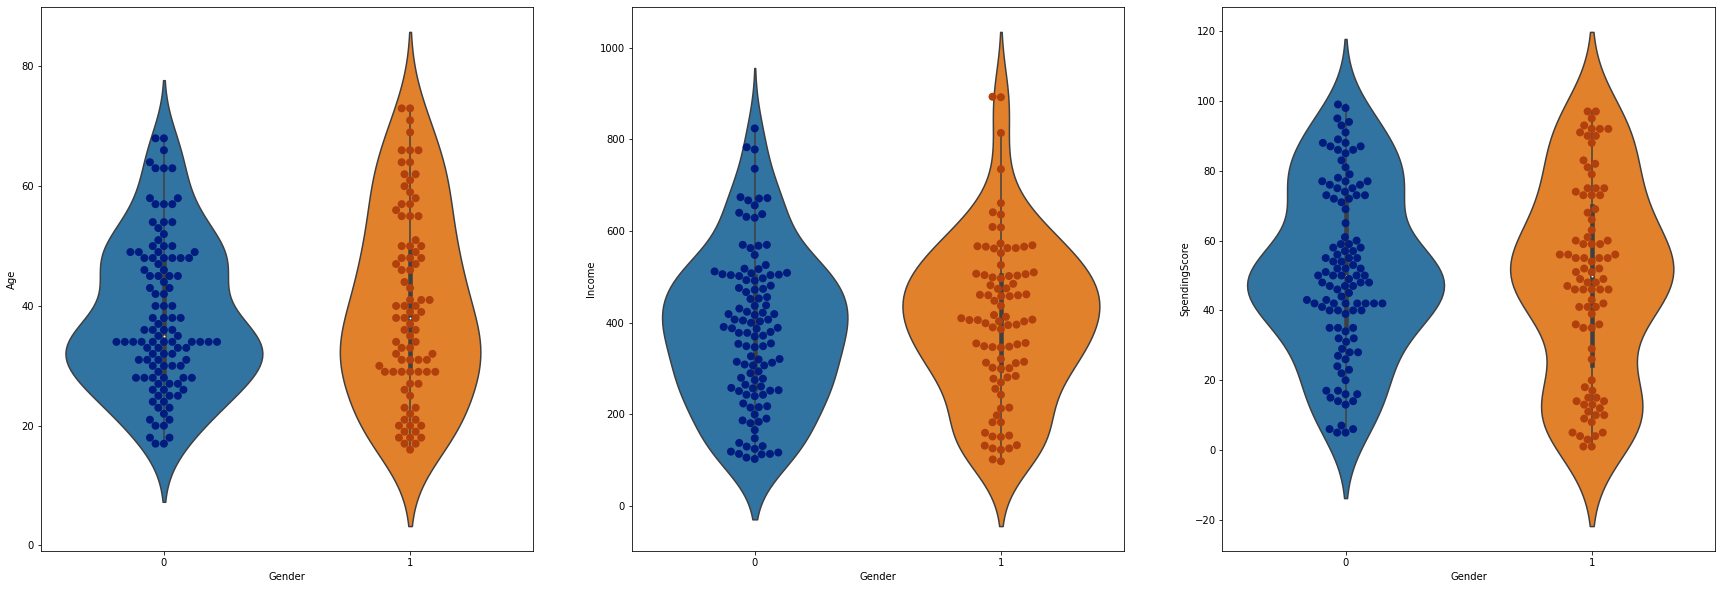

In [ ]:
# Violin Plot for Gender and differnt features
plt.figure(figsize = (30, 10))
for n, iter in enumerate(["Age", "Income", "SpendingScore"]):
  plt.subplot(1, 3, n + 1)
  sns.violinplot(data = encoded_customer_df, x = "Gender", y = iter )
  sns.swarmplot(data = encoded_customer_df, x = "Gender", y = iter, palette = "dark", size = 8)
plt.show()

## Summary on Encoded Data (Second Level)
- The statistics summary and histogram indicate that the average customer age is 39.1, that many customers are between the ages of 30 and 40, and that I have clients ranging in age from 16 to 73. 
- The average customer earns 393750 and are between 300000 to 500000. 
- It implied that my customer base is diverse, but the majority is likely middle-aged or middle-class.
- The SpedingScore of my customer is mainly between 40 to 60.
- The gender distribution is around 505-50%. This implies that my product is genuinely gender neutral. However, my data size is small. Additional analysis will be conducted.
- The violin plot demonstrates that the Income and SpendingScope distributions are nearly same, whereas males may be younger.

"SpendingScore", "Age" and "Income" will be normalized for further analysis

## Normalisation Data analysis

In [ ]:
# Normalised the features with MinMaxScaler()
train_min_max_scaler = MinMaxScaler().fit(encoded_customer_df)
train_norm_df = pd.DataFrame(train_min_max_scaler.transform(encoded_customer_df), columns = encoded_customer_df.columns)
# Check the first 6 rows after normalisation
train_norm_df.head(6)

,SpendingScore,Age,Income,Gender
0,0.89796,0.21053,0.51572,0.00000
1,0.81633,0.08772,0.14717,0.00000
2,0.51020,0.21053,0.24654,0.00000
3,0.28571,0.17544,0.44528,0.00000
4,0.03061,0.71930,0.14465,1.00000
5,0.55102,0.03509,0.25409,1.00000


In [ ]:
# Double check the Data Type again
train_norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SpendingScore  200 non-null    float64
 1   Age            200 non-null    float64
 2   Income         200 non-null    float64
 3   Gender         200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


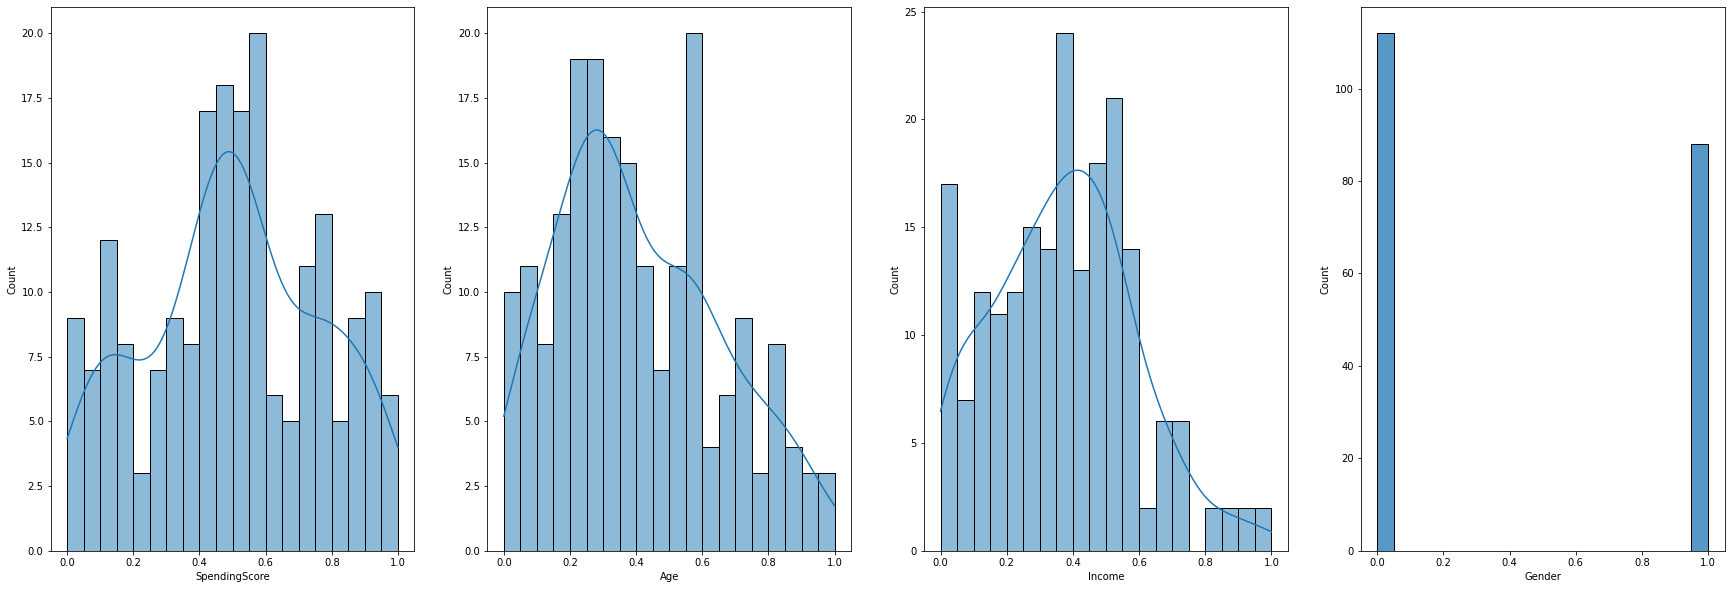

In [ ]:
# Plot the the normalised data histogram to ensure it falls between 0 and 1
plt.figure(figsize = (30, 10))
for n, iter in enumerate(train_norm_df.columns):
  plt.subplot(1, 4, n + 1)
  if iter == "Gender":
    sns.histplot(data = train_norm_df.loc[:,iter], bins = 20, kde = False)
  else:
    sns.histplot(data = train_norm_df.loc[:,iter], bins = 20, kde = True)
plt.show()

<Figure size 1080x1080 with 0 Axes>

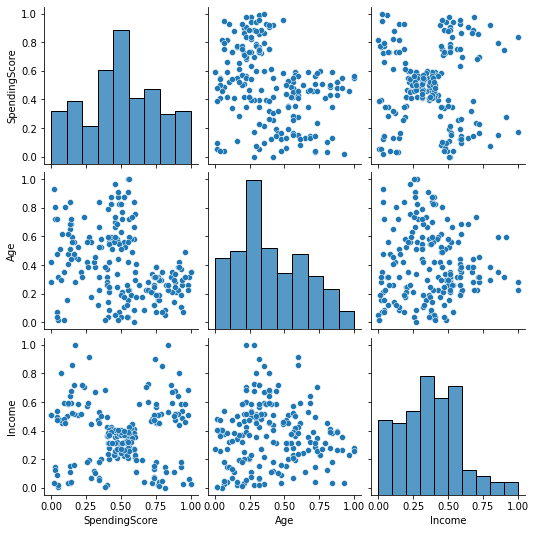

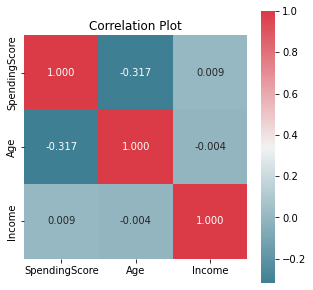

               SpendingScore      Age   Income
SpendingScore        1.00000 -0.31650  0.00946
Age                 -0.31650  1.00000 -0.00359
Income               0.00946 -0.00359  1.00000


In [ ]:
# Correlation plot bewteen non-binary attributes
plt.figure(figsize = (15, 15))
sns.pairplot(train_norm_df[["SpendingScore","Age", "Income"]])
plt.show()

corr = train_norm_df[["SpendingScore","Age", "Income"]].corr()
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot = True, fmt = '.3f')
plt.title("Correlation Plot")
plt.show()
print(corr)

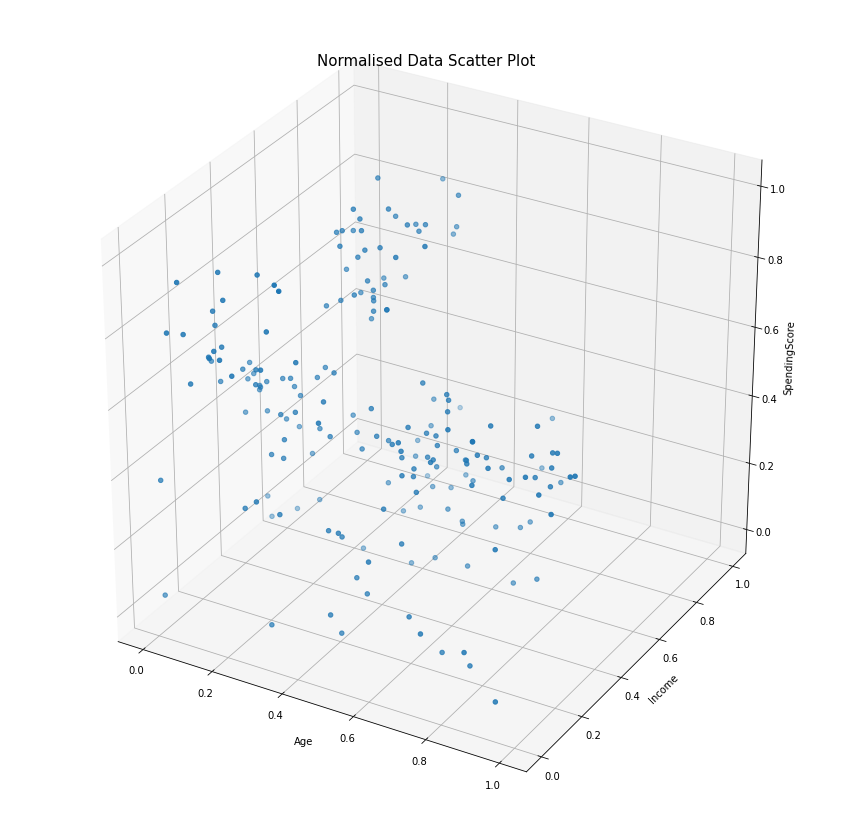

In [ ]:
# 3 Dimension scatter plot with Age, Income and SpendingScore 
fig = plt.figure(figsize=(15,15))
plot = fig.add_subplot(111, projection='3d')
plot.set_title("Normalised Data Scatter Plot", fontsize = 15)
plot.set_xlabel("Age")
plot.set_ylabel("Income")
plot.set_zlabel("SpendingScore")
sc = plot.scatter(xs = train_norm_df["Age"], ys = train_norm_df["Income"], zs = train_norm_df["SpendingScore"])
plt.show()

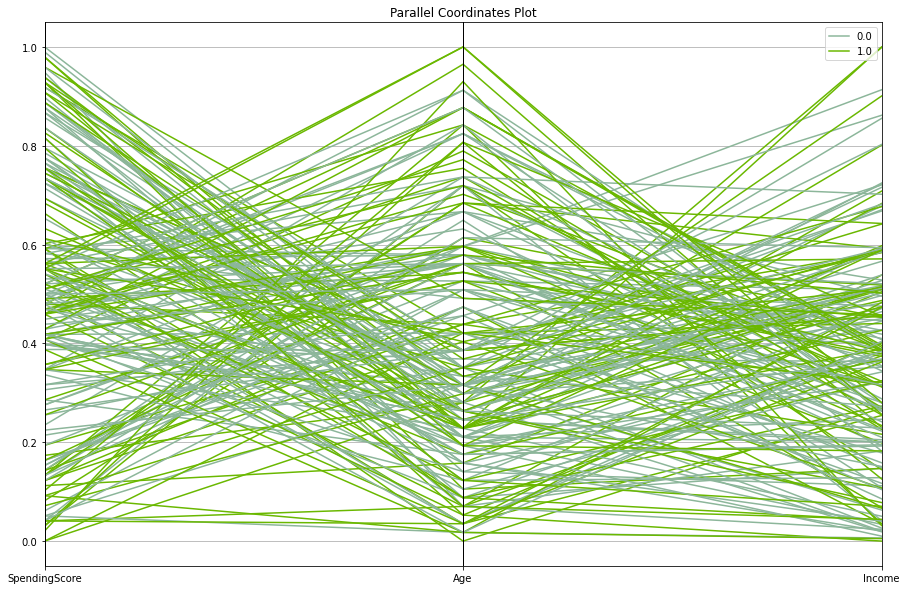

In [ ]:
# Parallel Coordinates Plot
plt.figure(figsize = (15, 10))
plotting.parallel_coordinates(train_norm_df, "Gender")
plt.title("Parallel Coordinates Plot")
plt.show()

## Summary on Normalised Data (Last Level)
- There is no obvious correlation between "Age", "Income" and "SpendingScore" (|corr| < 0.5)
- The plot of parallel coordinates demonstrates that there is no discernible difference between male and female. Ny product could be gender neutral.
- The correlation diagram indicates that there might be 4 to 6 clusters for "SpendingScore" and "Income." However, this is not my topic of interest, and it will be illustrated in the appendix for those who are curious. I would want to create a cluster with a more sophisticated dimension and also differentiate my customers by age.
- The number clusters are not immediately apparent in the 3-D figure above. I'm going to do unsupervised learning to see whether I can distinguish between different clients.

# Q3. From what you learn from the data, try to make appropriate recommendation to the management. 

## Models Fitting and Analysis

### Dimension Reduction

I am interested to see whether I can lower the dimension using PCA and still account for more than 90% of the variance ratio.

In [ ]:
# Set all the feature to X
X = train_norm_df[["SpendingScore","Age", "Income"]]

In [ ]:
# PCA for checking the eignvector
pca = PCA()
pca.fit(X)
print("PCA Variance Ratio:", np.round(pca.explained_variance_ratio_, 5))
print("PCA Cumulative Variance Ratio:", np.round(np.cumsum(pca.explained_variance_ratio_), 5))

PCA Variance Ratio: [0.48795 0.26317 0.24888]
PCA Cumulative Variance Ratio: [0.48795 0.75112 1.     ]


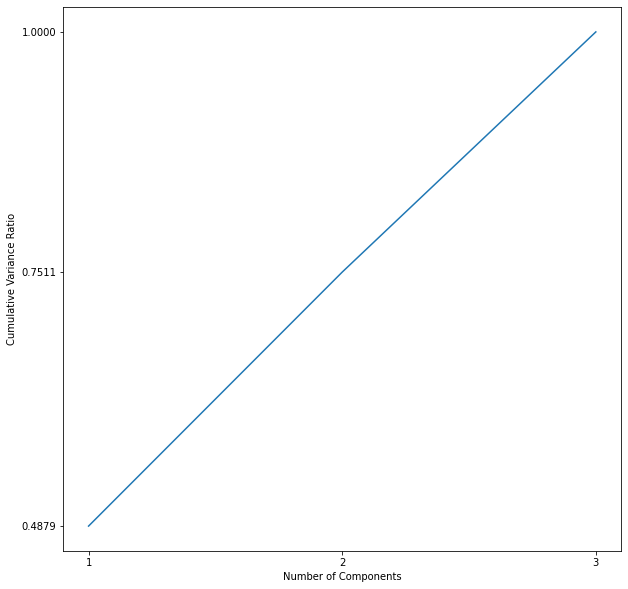

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([1,2,3], np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.cumsum(pca.explained_variance_ratio_))
plt.xticks([1,2,3])
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio");
plt.show()

This implies that dimension reduction cannot be accomplished with a variance ratio of 90%.

### Clustering

To begin, I'd want to determine a "reasonable" range for the number of clusters in order to shorten the model finding calculation time later.

In [ ]:
# KMean fitting with various K values by inspecting the first 10 K. Random_state = 0 for simplicity
kmeans_fitted_all = [KMeans(n_clusters = k, random_state = 0).fit(X) for k in range(1, 10)]

In [ ]:
# Calculate the inertia for KMean with various K values by inspecting the first 10 K.
kmean_inertias_all = [iter.inertia_ for iter in kmeans_fitted_all]

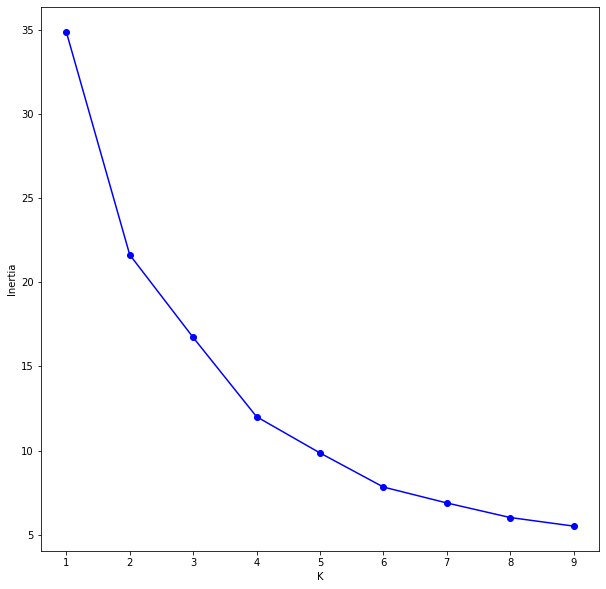

In [ ]:
# Elbow Method for checking the potential optima cluster
plt.figure(figsize=(10,10))
plt.plot(range(1, 10), kmean_inertias_all, "bo-") # k start from 1
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# Calcuate all fitted KMean silhouette
kmeans_silhouette_all = [silhouette_score((X), kmean_model.labels_, random_state=0) for kmean_model in kmeans_fitted_all[1:]] #  Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

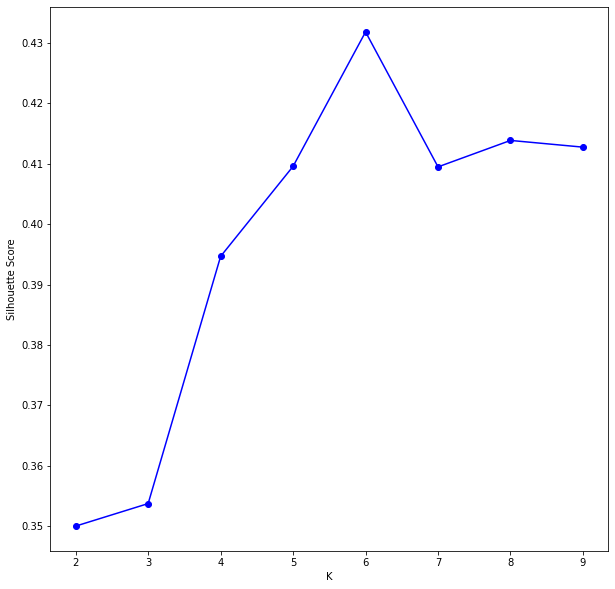

In [ ]:
# Visualise the silhouette fonud
plt.figure(figsize=(10, 10))
plt.plot(range(2, 10), kmeans_silhouette_all, "bo-") # K start from 2 for silhouette_score()
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()

It implies that K = 5 or 6 may be plausible clusters.

In [ ]:
# Model search with different models, random_state and n_init
k_range = [5,6] # The K range suggested above
init_range = range(1, 51) # 50 different init_range
rnd_state_range = range(0, 50) # 50 different rnd_state

# Variables for storing "best" silhouette score in each model
best_kmean_s_score = 0
best_accelerated_kmeans_s_score = 0
best_minibatch_s_score = 0

# Variables for storing the "best" inertia in each model
best_kmean_i = 0
best_accelerated_kmeans_i = 0
best_minibatch_i = 0

# Variables for storing the "best" parameters in each model
best_kmean_parameters = pd.DataFrame()
best_accelerated_kmeans_parameters = pd.DataFrame()
best_minibatch_parameters = pd.DataFrame()

# "Best" Model Search
# Because a larger K creates smaller inertia usually, silhouette scores are utilized for model assessment
for k_iter in k_range:
  for init_iter in init_range:
    for rnd_iter in rnd_state_range:
      # KMean 
      kmean_model = KMeans(n_clusters = k_iter, n_init = init_iter, algorithm = "full", random_state = rnd_iter).fit(X) # k-means++ by default
      kmean_s_score = silhouette_score((X), kmean_model.labels_, random_state = rnd_state_range)
      if ( kmean_s_score > best_kmean_s_score):
        best_kmean_s_score = kmean_s_score
        best_kmean_i = kmean_model.inertia_
        best_kmean_parameters = pd.DataFrame([[k_iter, init_iter, rnd_iter, best_kmean_i, best_kmean_s_score]], columns = ["k", "init", "rnd", "inertia", "silhouette"], index = ["KMean"])

      # Accelerated KMeans
      kmean_acce_model = KMeans(n_clusters = k_iter, n_init = init_iter, algorithm = "elkan", random_state = rnd_iter).fit(X) 
      accelerated_kmeans_s_score = silhouette_score((X), kmean_acce_model.labels_, random_state = rnd_state_range)
      if ( accelerated_kmeans_s_score > best_accelerated_kmeans_s_score):
        best_accelerated_kmeans_s_score = accelerated_kmeans_s_score
        best_accelerated_kmeans_i = kmean_acce_model.inertia_
        best_accelerated_kmeans_parameters = pd.DataFrame([[k_iter, init_iter, rnd_iter, best_accelerated_kmeans_i, best_accelerated_kmeans_s_score]], columns = ["k", "init", "rnd", "inertia", "silhouette"], index = ["Accelerated KMean"])

      # MiniBatch KMean
      kmenan_mini_model = MiniBatchKMeans(n_clusters = k_iter, n_init = init_iter, random_state = rnd_iter).fit(X)
      minibatch_s_score = silhouette_score((X), kmenan_mini_model.labels_, random_state = rnd_state_range)
      if ( minibatch_s_score > best_minibatch_s_score):
        best_minibatch_s_score = minibatch_s_score
        best_minibatch_i = kmenan_mini_model.inertia_
        best_minibatch_parameters = pd.DataFrame([[k_iter, init_iter, rnd_iter, best_minibatch_i, best_minibatch_s_score]], columns = ["k", "init", "rnd", "inertia", "silhouette"], index = ["Minibatch"])

      print("\rk_iter: {}/{}".format(k_iter - 4, 2), ", init_iter: {}/{}".format(init_iter, 50), ", rnd_iter {}/{}".format(rnd_iter + 1, 50),end="") # Check the current iteration

k_iter: 2/2 , init_iter: 50/50 , rnd_iter 50/50

In [ ]:
# "Best" KMean 
best_kmean_parameters

,k,init,rnd,inertia,silhouette
KMean,6,5,38,7.87384,0.43467


In [ ]:
# "Best" Accelerated KMean 
best_accelerated_kmeans_parameters

,k,init,rnd,inertia,silhouette
Accelerated KMean,6,5,38,7.87384,0.43467


In [ ]:
# "Best" MiniBatch KMean 
best_minibatch_parameters

,k,init,rnd,inertia,silhouette
Minibatch,6,16,6,7.89873,0.43796


In [ ]:
# Array for store the best model
best_models_list = []

# Obtain the correspponing "Best" fitted models
# KMean
kmeans_best_model_fit = KMeans(n_clusters = best_kmean_parameters.iloc[0,0], n_init = best_kmean_parameters.iloc[0,1], algorithm = "full", random_state = best_kmean_parameters.iloc[0,2]).fit(X)
best_models_list.append(kmeans_best_model_fit)
# Accelerated KMean
kmeans_acce_best_model_fit = KMeans(n_clusters = best_accelerated_kmeans_parameters.iloc[0,0], n_init = best_accelerated_kmeans_parameters.iloc[0,1], algorithm = "elkan", random_state = best_accelerated_kmeans_parameters.iloc[0,2]).fit(X)
best_models_list.append(kmeans_acce_best_model_fit)
# MiniBatch KMean
kmeans_mini_best_model_fit = MiniBatchKMeans(n_clusters = best_minibatch_parameters.iloc[0,0], n_init = best_minibatch_parameters.iloc[0,1],random_state = best_minibatch_parameters.iloc[0,2]).fit(X)
best_models_list.append(kmeans_mini_best_model_fit)

In [ ]:
# Concatenate the inertia and silhouette in a new DataFrame
iertias_n_silhouette = pd.DataFrame()
for model in [best_kmean_parameters, best_accelerated_kmeans_parameters, best_minibatch_parameters]:
  iertias_n_silhouette = pd.concat([iertias_n_silhouette, model.iloc[:,-2:]])

In [ ]:
# Check the score for each model
iertias_n_silhouette

,inertia,silhouette
KMean,7.87384,0.43467
Accelerated KMean,7.87384,0.43467
Minibatch,7.89873,0.43796


In [ ]:
# "Best" DBSCAN search
# Search ranges
eps_range = np.arange(0.05,0.30,0.01)
min_sample_range = range(5, 31)

# Variables for storing "best" silhouette score
best_dbscan_s_score = 0

# Variables for storing the "best" parameters in each model
best_dbscan_parameters = pd.DataFrame()

# "Best" Model Search
for eps_iter in eps_range:
  for min_sample_iter in min_sample_range:
    if eps_iter*100 < min_sample_iter: # Otherwise, error
      continue
    dbscan = DBSCAN(eps = eps_iter, min_samples = min_sample_iter).fit(X)
    dbscan_s_score = silhouette_score((X), dbscan.labels_)
    if dbscan_s_score > best_dbscan_s_score:
      best_dbscan_s_score = dbscan_s_score
      best_dbscan_parameters = pd.DataFrame([[eps_iter, min_sample_iter, None, best_dbscan_s_score]], columns = ["eps", "min_sample", "inertia", "silhouette"], index = ["DBSCAN"]) # inertia not for DBSCAN
    print("\reps_iter: {}/{}".format(round(eps_iter*100) - 4, 25), ", min_sample_iter: {}/{}".format(min_sample_iter - 4, 25),end="") 

eps_iter: 25/25 , min_sample_iter: 25/25

In [ ]:
# "Best" DBSCAN
best_dbscan_parameters

,eps,min_sample,inertia,silhouette
DBSCAN,0.29000,14,None,0.33276


In [ ]:
# Store the best model
best_models_list.append(DBSCAN(eps = best_dbscan_parameters.iloc[0,0], min_samples = best_dbscan_parameters.iloc[0,1]).fit(X))

In [ ]:
# Concatenate the DBSCAN silhouette in iertias_n_silhouette
iertias_n_silhouette = pd.concat([iertias_n_silhouette, best_dbscan_parameters.iloc[:,-2:]])

In [ ]:
# Check the model score
iertias_n_silhouette

,inertia,silhouette
KMean,7.87384,0.43467
Accelerated KMean,7.87384,0.43467
Minibatch,7.89873,0.43796
DBSCAN,NaN,0.33276


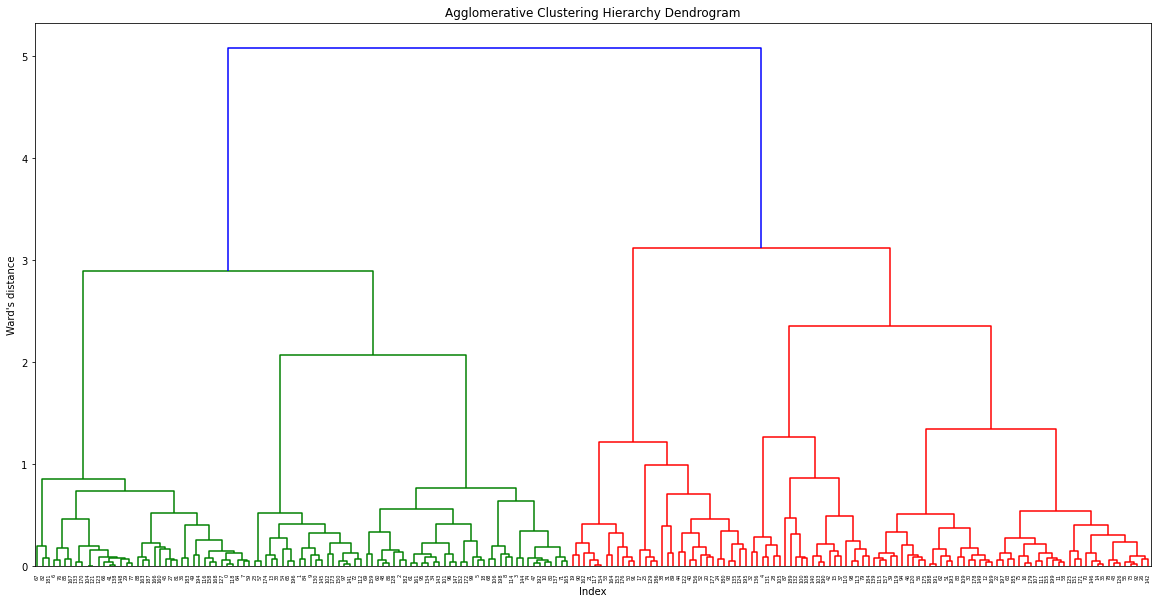

In [ ]:
# Agglomerative Clustering (Hierarchy Clustering) visualization
plt.figure(figsize=(20,10))
plt.title("Agglomerative Clustering Hierarchy Dendrogram")
plt.xlabel("Index")
plt.ylabel("Ward's distance")
dendrogram(linkage(X, 'ward'), leaf_rotation=90)
plt.show()

In [ ]:
# "Best" Agglomerative Clustering Search
# Search range
n_cluster_range = range(2, 12)

# Variable for storing the best silhouette score
best_agg_s_score = 0

# Variable for storing the best parameters
best_aggparameters = pd.DataFrame()

# "Best" Model Search
for n_cluster_iter in n_cluster_range:
    agg = AgglomerativeClustering(linkage ='ward', n_clusters = n_cluster_iter).fit(X)
    agg_s_score = silhouette_score((X), agg.labels_)
    if agg_s_score > best_agg_s_score:
      best_agg_s_score = agg_s_score
      best_aggparameters = pd.DataFrame([[n_cluster_iter, None, best_agg_s_score]], columns = ["n_cluster", "inertia", "silhouette"], index = ["AGG"]) # inertia not for DBSCAN
    print("\rn_cluster_iter: {}/{}".format(n_cluster_iter - 1, 10),end="")

n_cluster_iter: 10/10

In [ ]:
# "Best" Agglomerative Clustering
best_aggparameters

,n_cluster,inertia,silhouette
AGG,6,None,0.42983


In [ ]:
# Store the best model
best_models_list.append(AgglomerativeClustering(linkage ='ward', n_clusters = best_aggparameters.iloc[0,0]).fit(X))

In [ ]:
# Concatenate the silhouette in iertias_n_silhouette
iertias_n_silhouette = pd.concat([iertias_n_silhouette, best_aggparameters.iloc[:,-2:]])

In [ ]:
# Check the model score
iertias_n_silhouette

,inertia,silhouette
KMean,7.87384,0.43467
Accelerated KMean,7.87384,0.43467
Minibatch,7.89873,0.43796
DBSCAN,NaN,0.33276
AGG,NaN,0.42983


In [ ]:
best_models_list

[KMeans(algorithm='full', n_clusters=6, n_init=5, random_state=38),
 KMeans(algorithm='elkan', n_clusters=6, n_init=5, random_state=38),
 MiniBatchKMeans(n_clusters=6, n_init=16, random_state=6),
 DBSCAN(eps=0.29000000000000004, min_samples=14),
 AgglomerativeClustering(n_clusters=6)]

In [ ]:
# Data Clustering with "best" model from iertias_n_silhouette
best_model = best_models_list[0]
y_kmeans_best = best_model.predict(X)

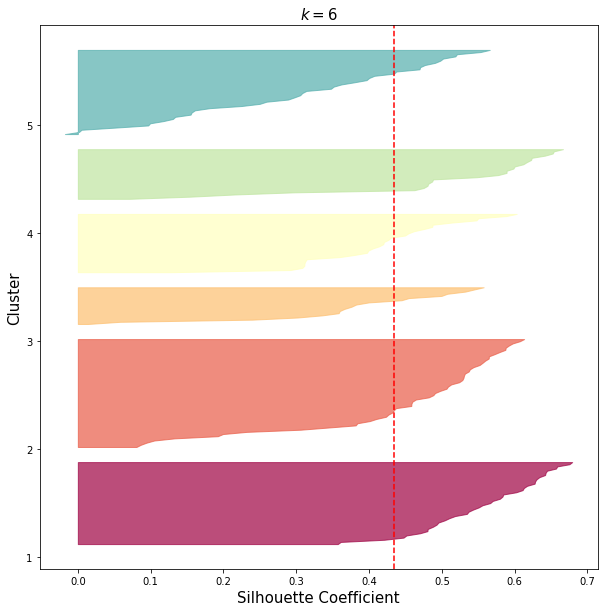

In [ ]:
# silhouette_analysis_plot with "Best" model (Reference to Professor Topic 7)

plt.figure(figsize=(10, 10))
silhouette_coefficients = silhouette_samples(X, y_kmeans_best)

padding = len(X) // 30
pos = padding

k = 6

for i in range(k):
  coeffs = silhouette_coefficients[y_kmeans_best == i]
  coeffs.sort()
  color = mpl.cm.Spectral(i / k)
  plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                    facecolor=color, edgecolor=color, alpha=0.7)
  pos += len(coeffs) + padding

plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
plt.ylabel("Cluster", fontsize = 15)
plt.xlabel("Silhouette Coefficient", fontsize = 15)
plt.axvline(x = iertias_n_silhouette.iloc[0,1], color="red", linestyle="--")
plt.title("$k={}$".format(k), fontsize = 15)
plt.show()

In [ ]:
# Add the cluster and gender back for analysis
df = X.copy()
df["Gender"] = train_norm_df["Gender"]
df["KMean"] = y_kmeans_best = kmeans_best_model_fit.predict(X)
df.head(6)

,SpendingScore,Age,Income,Gender,KMean
0,0.89796,0.21053,0.51572,0.00000,0
1,0.81633,0.08772,0.14717,0.00000,4
2,0.51020,0.21053,0.24654,0.00000,5
3,0.28571,0.17544,0.44528,0.00000,5
4,0.03061,0.71930,0.14465,1.00000,2
5,0.55102,0.03509,0.25409,1.00000,5


In [ ]:
# Gender distribution (expected) for each class
for iter in range(6): # "Optimal" Clusters is 6
  print("Cluster", iter, "expected Gender Mean:", '%.5f' % df.loc[ df["KMean"] == iter,:].describe()["Gender"][1])

Cluster 0 expected Gender Mean: 0.46154
Cluster 1 expected Gender Mean: 0.45098
Cluster 2 expected Gender Mean: 0.44444
Cluster 3 expected Gender Mean: 0.50000
Cluster 4 expected Gender Mean: 0.41667
Cluster 5 expected Gender Mean: 0.37500


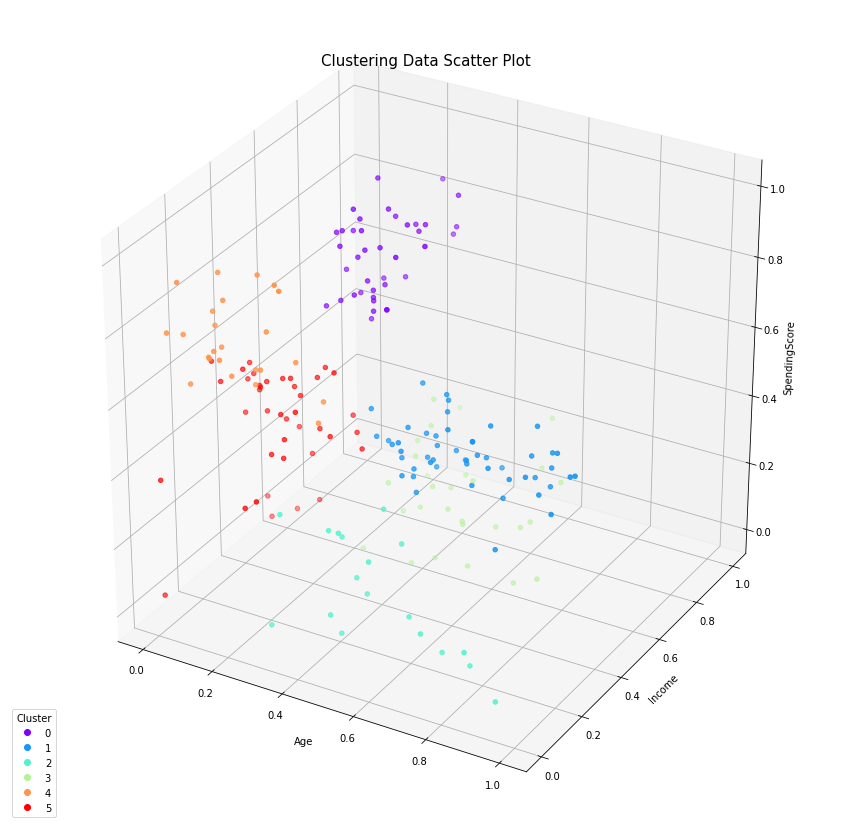

In [ ]:
# 3 Dimension plot of the SpendingScore scatter plot with Age, Income and Gender 
fig = plt.figure(figsize=(15,15))
plot = fig.add_subplot(111, projection='3d')
plot.set_title("Clustering Data Scatter Plot", fontsize = 15)
plot.set_xlabel("Age")
plot.set_ylabel("Income")
plot.set_zlabel("SpendingScore")
sc = plot.scatter(xs = df["Age"], ys = df["Income"], zs = df["SpendingScore"], c = df["KMean"], cmap = "rainbow")
plot.legend(handles = sc.legend_elements()[0], loc="lower left", title="Cluster", labels = [0,1,2,3,4,5], fontsize = 10)
plt.show()

<Figure size 1080x1080 with 0 Axes>

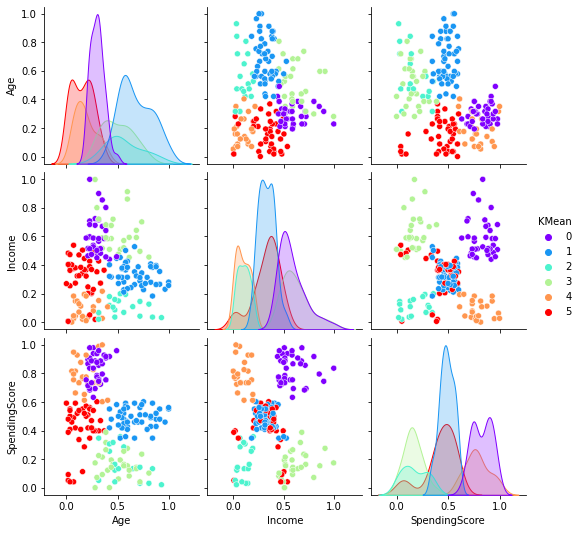

In [ ]:
# Project the 3D plot into 2D
plt.figure(figsize=(15,15))
sns.pairplot(df[["Age","Income","SpendingScore","KMean"]], hue="KMean", palette = "rainbow")
plt.show()

## Summary
- Suggested Model is KMeans(algorithm='full', n_clusters=6, n_init=5, random_state=38).
- I can offer my customers 6 distinct loyalty programs and promotional campaigns based on their Age, Income, and SpendingScore. For instance, one for younger with a median income and a median spending score (Cluster 5) and another for older with a median income and a median spending score (Cluster 1). Even though their income and SpendingScores are comparable, they may have diverse preferences due to their age difference.
- As predicted, the KMean clustering was chosen since it is a Centroid-based clustering algorithm, whereas DBSCAN is a Density-based clustering algorithm and Hierarchical clustering is a Connectivity-based clustering algorithm. The three-dimensional plot and data scarcity may indicate that KMean is the superior choice.
- My product is genuinely gender neutral as the estimated gender mean for each cluster is about 50%.
- The MiniBatch KMean's silhouette is slightly higher than that of the KMeans or Accelerated KMeans. Its insertia, on the other hand, is significantly greater. Additionally, KMeans and Accelerated KMeans both offer the same approach. (The dataset is small as a result there is no difference) KMeans was chosen as the "best" model.

# Appendix

## Clustering ("SpendingScore", "Income")

For those interested in unsupervised learning, the labels "SpendingScore" and "Income".

In [ ]:
# KMean fitting with various K values by inspecting the first 10 K.random_state = 0 for simplicity
kmeans_fitted_all_appendix_ = [KMeans(n_clusters = k, random_state = 0).fit(X[["SpendingScore", "Income"]]) for k in range(1, 10)]
# Calcuate all fitted intertias
kmean_inertias_all_appendix_ = [iter.inertia_ for iter in kmeans_fitted_all_appendix_]
# Calcuate all fitted silhouette score
kmeans_silhouette_all_appendix_ = [silhouette_score((X), iter.labels_, random_state = 0) for iter in kmeans_fitted_all_appendix_[1:]] 

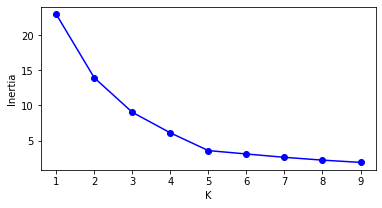

In [ ]:
# Elbow method for finding the "Best" K
plt.figure(figsize=(6,3))
plt.plot(range(1, 10), kmean_inertias_all_appendix_, "bo-") # k start from 1
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

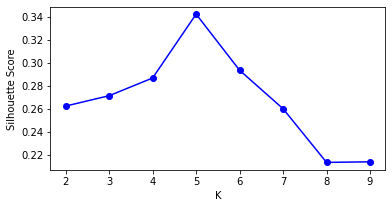

In [ ]:
# Finding the "best" K with silhouette score
plt.figure(figsize=(6, 3))
plt.plot(range(2, 10), kmeans_silhouette_all_appendix_, "bo-") # K start from 2 for silhouette_score()
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
# To keep things simple, I used K = 5 as mentioned previously. Kindly conduct a model search if feasible.
n = 5
kmeans_appendix = KMeans(n_clusters = n, random_state = 0)
kmeans_appendix.fit(X[["SpendingScore","Income"]])
y_kmeans_appendix = kmeans_appendix.predict(X[["SpendingScore","Income"]])
appendix_df = X.copy()
appendix_df["Cluster"] = y_kmeans_appendix

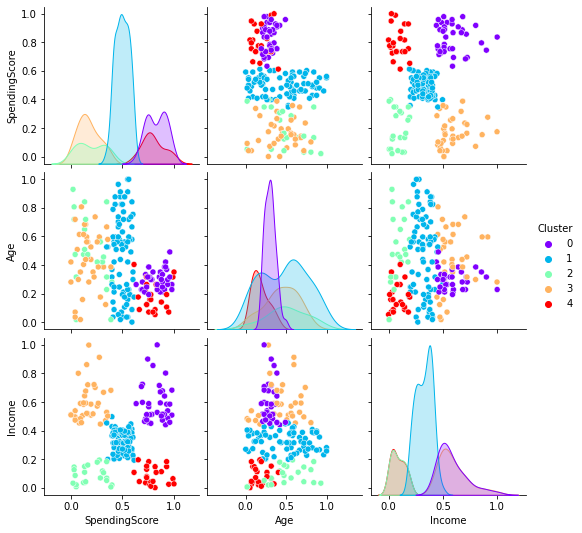

In [ ]:
sns.pairplot(appendix_df, hue = "Cluster", palette = "rainbow")
plt.show()

In [ ]:
appendix_df.groupby(["Cluster"]).size()

Cluster
0    39
1    81
2    22
3    36
4    22
dtype: int64

## Finding
- Proposal model is KMeans(n_clusters = 5, random_state = 0)
- I can propose a loyalty program or campaign based on the SpendingScore and Income of 5 distinct client segments, regardless of their age.
- Medium-income customer concentrate at mid SpendingScore.
- Both High- and Low-income consumers have a high or low SpendingScore.
- The number of High-income (Cluster 0 and 3) customers is comparable to the number of Medium-income (Cluster 1) customers, and either one is more than the number of Low-income (Cluster 2 and 4) consumers.
- The number of High-SpendingScore (Cluster 0 and 4) customers is comparable to the number of Low-SpendingScore (Cluster 2 and 3) customers, and either one is smaller than the number of Medium-SpendingScore (Cluster 1) consumers.